In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import utils
import importlib
importlib.reload(utils)
from utils import *
import re, string, collections, pickle, os # bcolz
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB, MultinomialNB

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zoe_k\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\zoe_k\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\zoe_k\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zoe_k\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('trustpilot.csv', lineterminator='\n')
df.shape
df.head()

,url,reviewContentTitle,reviewContentText,time,stars,name,numberOfReviews\r\r
0,https://nl.trustpilot.com/review/dekbed-discou...,Heerlijke kussens gekocht slaap nu veel…,Heerlijke kussens gekocht slaap nu veel beter ...,"{""publishedDate"":""2019-01-24T07:52:25Z"",""updat...",star-rating star-rating-5 star-rating--medium,Jantje rouwkema,1 review\r\r
1,https://nl.trustpilot.com/review/dekbed-discou...,Fijne webshop!,"Fijne webshop, snelle verzending en mooie dege...","{""publishedDate"":""2019-01-24T07:03:13Z"",""updat...",star-rating star-rating-5 star-rating--medium,Marielle van Gulik,1 review\r\r
2,https://nl.trustpilot.com/review/dekbed-discou...,Top winkel!,"Geweldige winkel! Goede service, goedkoop, goe...","{""publishedDate"":""2019-01-24T00:01:38Z"",""updat...",star-rating star-rating-5 star-rating--medium,Lianne Van Rixel,1 review\r\r
3,https://nl.trustpilot.com/review/dekbed-discou...,Vlotte snelle levering voor een mooie…,Vlotte snelle levering voor een mooie prijs.,"{""publishedDate"":""2019-01-23T23:39:49Z"",""updat...",star-rating star-rating-5 star-rating--medium,MAS vanBemmel,1 review\r\r
4,https://nl.trustpilot.com/review/dekbed-discou...,"Klantenservice is super, heel coulant bij gere...",Ik ben heel erg tevreden met de klantenservice...,"{""publishedDate"":""2019-01-23T23:28:38Z"",""updat...",star-rating star-rating-5 star-rating--medium,Annette Urban,1 review\r\r


In [3]:
df['stars'].replace(['star-rating star-rating-5 star-rating--medium'], ['5'], inplace=True)
df['stars'].replace(['star-rating star-rating-4 star-rating--medium'], ['4'], inplace=True)
df['stars'].replace(['star-rating star-rating-3 star-rating--medium'], ['3'], inplace=True)
df['stars'].replace(['star-rating star-rating-2 star-rating--medium'], ['2'], inplace=True)
df['stars'].replace(['star-rating star-rating-1 star-rating--medium'], ['1'], inplace=True)
df['stars'].replace(['star-rating star-rating-0 star-rating--medium'], ['1'], inplace=True)

In [4]:
df.head()

,url,reviewContentTitle,reviewContentText,time,stars,name,numberOfReviews\r\r
0,https://nl.trustpilot.com/review/dekbed-discou...,Heerlijke kussens gekocht slaap nu veel…,Heerlijke kussens gekocht slaap nu veel beter ...,"{""publishedDate"":""2019-01-24T07:52:25Z"",""updat...",5,Jantje rouwkema,1 review\r\r
1,https://nl.trustpilot.com/review/dekbed-discou...,Fijne webshop!,"Fijne webshop, snelle verzending en mooie dege...","{""publishedDate"":""2019-01-24T07:03:13Z"",""updat...",5,Marielle van Gulik,1 review\r\r
2,https://nl.trustpilot.com/review/dekbed-discou...,Top winkel!,"Geweldige winkel! Goede service, goedkoop, goe...","{""publishedDate"":""2019-01-24T00:01:38Z"",""updat...",5,Lianne Van Rixel,1 review\r\r
3,https://nl.trustpilot.com/review/dekbed-discou...,Vlotte snelle levering voor een mooie…,Vlotte snelle levering voor een mooie prijs.,"{""publishedDate"":""2019-01-23T23:39:49Z"",""updat...",5,MAS vanBemmel,1 review\r\r
4,https://nl.trustpilot.com/review/dekbed-discou...,"Klantenservice is super, heel coulant bij gere...",Ik ben heel erg tevreden met de klantenservice...,"{""publishedDate"":""2019-01-23T23:28:38Z"",""updat...",5,Annette Urban,1 review\r\r


In [5]:
df.columns

Index(['url', 'reviewContentTitle', 'reviewContentText', 'time', 'stars',
       'name', 'numberOfReviews\r\r'],
      dtype='object')

In [6]:
df=df.rename(columns = {'reviewContentTitle':'Review_Title', 'reviewContentText':'text', 'numberOfReviews\r\r':'Number_of_Reviews'})

In [7]:
df.drop(['url','Review_Title', 'time', 'name', 'Number_of_Reviews'], axis=1, inplace=True)

In [8]:
df.head()

,text,stars
0,Heerlijke kussens gekocht slaap nu veel beter ...,5
1,"Fijne webshop, snelle verzending en mooie dege...",5
2,"Geweldige winkel! Goede service, goedkoop, goe...",5
3,Vlotte snelle levering voor een mooie prijs.,5
4,Ik ben heel erg tevreden met de klantenservice...,5


# Filter negative & positive reviews

In [9]:
df.dtypes

text     object
stars    object
dtype: object

In [10]:
df['stars']=df.stars.astype(int)
df['text']=df.text.astype(str)

In [11]:
df.dtypes

text     object
stars     int32
dtype: object

# Filter negative & positive reviews

In [12]:
pos = df.loc[df['stars'] > 4, 'text'].copy().reset_index(drop=True)
neg = df.loc[df['stars'] < 3, 'text'].copy().reset_index(drop=True)
print(len(pos), len(neg))

495477 41224


In [13]:
# Positive examples
print(''.join(pos[np.random.randint(0, len(pos))]))

Makkelijk besteld en snel geleverd. Helemaal tevreden!


In [14]:
# Negative examples
print(''.join(neg[np.random.randint(0, len(neg))]))

Zeer slechte service. Mijn bestelling is niet geleverd en dit probleem wordt niet opgelost. Uiteraard zal ik bol.com niet aanbevelen.


# Add class labels: 0 for negative reviews, 1 for positive reviews

In [15]:
neg = pd.concat([pd.DataFrame(neg), pd.DataFrame(np.zeros(neg.shape), columns=['class'])], 1)
pos = pd.concat([pd.DataFrame(pos), pd.DataFrame(np.ones(pos.shape), columns=['class'])], 1)

# Make homogeneous review length

480.2441538909373 545.0986816871941 11326


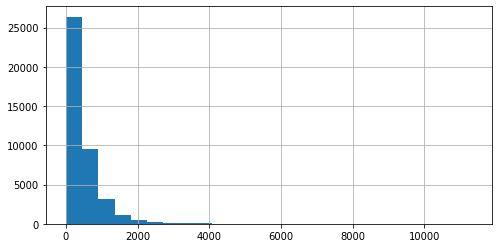

In [16]:
# Mean, standard deviation and max length (no. of characters)
# Negative reviews
lens = neg['text'].str.len()
print(lens.mean(), lens.std(), lens.max())
lens.hist(figsize=(8, 4), bins=25)

121.2036239825461 128.50196120229057 9926


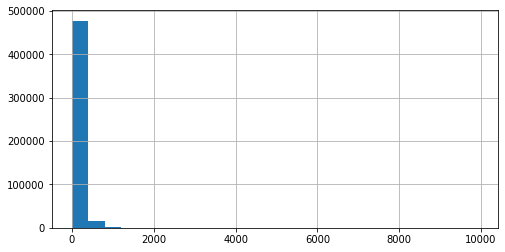

In [17]:
# Positive reviews
lens = pos['text'].str.len()
print(lens.mean(), lens.std(), lens.max())
lens.hist(figsize=(8, 4), bins=25)

In [18]:
# Reviews with more than 5000 characters are dropped
# Negative reviews
long_reviews = neg.loc[neg['text'].str.len() > 5000].index
neg.drop(long_reviews, inplace=True)
# Positive reviews
long_reviews = pos.loc[pos['text'].str.len() > 5000].index
pos.drop(long_reviews, inplace=True)

# Balance class sizes

In [19]:
np.random.seed(42)
rand = np.random.permutation(pos.shape[0])
pos = pos.iloc[rand[:neg.shape[0]]].reset_index(drop=True)
print(neg.shape, pos.shape)

(41173, 2) (41173, 2)


In [20]:
#!# We educe the dataset further so that it computes faster
#1# Better models may require the full dataset
np.random.seed(42)
rand = np.random.permutation(pos.shape[0])
pos = pos.iloc[rand[:10000]].reset_index(drop=True)
rand = np.random.permutation(neg.shape[0])
neg = neg.iloc[rand[:10000]].reset_index(drop=True)

In [21]:
# We merge the positive and negative reviews, and suffle the rows
df = pd.concat([pos, neg]).sample(frac=1, random_state=42).reset_index(drop=True)
print(df.shape)
df.head()

(20000, 2)


,text,class
0,heb erg lang moeten wachten voordat me bestell...,0.0
1,Goede ervaring,1.0
2,Ik kies elke keer toch weer Albelli voor mijn ...,1.0
3,Decided to change colour of the chairs I'd ord...,1.0
4,1 pagina zat in het midden aan elkaar geplakt....,0.0


# Tokenize & Lemmatize (extract clean words)

In [22]:
# Replacing carriage returns \r
df['text'] = df['text'].str.replace('\r',' ')

In [23]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

for i in range(df.shape[0]):
    clean_tokens = ''
    for w in word_tokenize(df.loc[:, ('text')][i]):
        if w not in stop_words:
            clean_tokens = clean_tokens + ' ' + lemmatizer.lemmatize(w)
    df['text'][i] = clean_tokens.translate(str.maketrans('', '', string.punctuation))

C:\Users\zoe_k\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [24]:
df.head()

,text,class
0,heb erg lang moeten wachten voordat bestellin...,0.0
1,Goede ervaring,1.0
2,Ik ky elke keer toch weer Albelli voor mijn f...,1.0
3,Decided change colour chair I d ordered No p...,1.0
4,1 pagina zat het midden aan elkaar geplakt B...,0.0


# Use Part-of-Speech (pos) to Lemmatize

In [25]:
print(nltk.pos_tag(word_tokenize(df['text'][1])))

[('Goede', 'NNP'), ('ervaring', 'VBG')]


In [26]:
# https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
from nltk.corpus import wordnet
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [27]:
for i in range(3):
    print(df['text'][i])
    print([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_tokenize(df['text'][i])])
    print('\n')

 heb erg lang moeten wachten voordat bestelling binnen stond binnen 23 werkdagen maar werd 2 weken😥
['heb', 'erg', 'lang', 'moeten', 'wachten', 'voordat', 'bestelling', 'binnen', 'stond', 'binnen', '23', 'werkdagen', 'maar', 'werd', '2', 'weken😥']


 Goede ervaring
['Goede', 'ervaring']


 Ik ky elke keer toch weer Albelli voor mijn fotoboeken en foto op linnenIk betaal liever iets meer mocht ik niet tevreden zijn dan geeft Albelli de 100  tevredenheidgarantieMaar ben tot nu toe elke keer dik tevreden de productenAlleen de bezorging van het product door GLS ik de afgelopen keer niet tevreden maar heb zowel contact gehad met GLS en Albelli en alsnog goed gekomen 
['Ik', 'ky', 'elke', 'keer', 'toch', 'weer', 'Albelli', 'voor', 'mijn', 'fotoboeken', 'en', 'foto', 'op', 'linnenIk', 'betaal', 'liever', 'iets', 'meer', 'mocht', 'ik', 'niet', 'tevreden', 'zijn', 'dan', 'geeft', 'Albelli', 'de', '100', 'tevredenheidgarantieMaar', 'ben', 'tot', 'nu', 'toe', 'elke', 'keer', 'dik', 'tevreden', 'd

In [28]:
def get_clean_token(txt):
    return [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_tokenize(txt)]

vect = CountVectorizer(tokenizer=get_clean_token)

# Split and tokenize

In [29]:
X_train, X_test, y_train, y_test = train_test_split(df['text'].values, df['class'].values, test_size=0.2, random_state=42)